<a href="https://colab.research.google.com/github/DMT130/Costal-Monitoring/blob/main/kenmare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyGMTSAR Flooding [Correlation] Map: Kalkarindji, NT Australia, 2024

The PyGMTSAR InSAR library, Geomed3D Geophysical Inversion Library, N-Cube 3D/4D GIS Data Visualization, among others, are my open-source projects developed in my free time. I hold a Master's degree in STEM, specializing in radio physics. In 2004, I received the first prize in the All-Russian Physics Competition for significant results in forward and inverse modeling for nonlinear optics and holography. These skills are also applicable to modeling Gravity, Magnetic, and Thermal fields, as well as satellite interferometry processing. With 20 years of experience as a data scientist and software developer, I have contributed to scientific and industrial development, working on government contracts, university projects, and with companies like LG Corp and Google Inc.

You can support my work on [Patreon](https://www.patreon.com/pechnikov), where I share updates on my projects, publications, use cases, examples, and other useful information. For research and development services and support, please visit my profile on the freelance platform [Upwork](https://www.upwork.com).

### Resources
- Google Colab Pro notebooks and articles on [Patreon](https://www.patreon.com/pechnikov),
- Google Colab notebooks on [GitHub](https://github.com),
- Docker Images on [DockerHub](https://hub.docker.com),
- Geological Models on [YouTube](https://www.youtube.com),
- VR/AR Geological Models on [GitHub](https://github.com),
- Live updates and announcements on [LinkedIn](https://www.linkedin.com/in/alexey-pechnikov/).

© Alexey Pechnikov, 2024

$\large\color{blue}{\text{Hint: Use menu Cell} \to \text{Run All or Runtime} \to \text{Complete All or Runtime} \to \text{Run All}}$
$\large\color{blue}{\text{(depending of your localization settings) to execute the entire notebook}}$

## Load Modules to Check Environment

In [3]:
import platform, sys, os

## Google Colab Installation

### Install GMTSAR
https://github.com/gmtsar/gmtsar

In [4]:
if 'google.colab' in sys.modules:
    count = !ls /usr/local | grep GMTSAR | wc -l
    if count == ['0']:
        !export DEBIAN_FRONTEND=noninteractive
        !apt-get update > /dev/null
        !apt install -y csh autoconf gfortran \
            libtiff5-dev libhdf5-dev liblapack-dev libgmt-dev gmt > /dev/null
        # GMTSAR codes are not so good to be compiled by modern GCC
        !apt install gcc-9 > /dev/null
        !update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 10
        !update-alternatives --config gcc
        !gcc --version | head -n 1
        !rm -fr /usr/local/GMTSAR
        !git config --global advice.detachedHead false
        !cd /usr/local && git clone -q --branch master https://github.com/gmtsar/gmtsar GMTSAR
        # revert recent broken commit
        !cd /usr/local/GMTSAR && git checkout e98ebc0f4164939a4780b1534bac186924d7c998 > /dev/null
        !cd /usr/local/GMTSAR && autoconf > /dev/null
        !cd /usr/local/GMTSAR && ./configure --with-orbits-dir=/tmp > /dev/null
        !cd /usr/local/GMTSAR && make 1>/dev/null 2>/dev/null
        !cd /usr/local/GMTSAR && make install >/dev/null
        # test one GMTSAR binary
        !/usr/local/GMTSAR/bin/make_s1a_tops 2>&1 | head -n 2

In [5]:
import sys
if 'google.colab' in sys.modules:
    !apt install -y xvfb > /dev/null
    !{sys.executable} -m pip install pyvista xvfbwrapper > /dev/null
    import xvfbwrapper
    display = xvfbwrapper.Xvfb(width=800, height=600)
    display.start()

### Define ENV Variables for Jupyter Instance

In [6]:
# use default GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/usr/local/GMTSAR/bin/


### Install Python Modules

Maybe you need to restart your notebook, follow the instructions printing below.

The installation takes a long time on fresh Debian 10 and a short time on Google Colab

In [7]:
!{sys.executable} --version

Python 3.10.12


In [8]:
if 'google.colab' in sys.modules:
    #!{sys.executable} -m pip install -Uq git+https://github.com/mobigroup/gmtsar.git@pygmtsar2#subdirectory=pygmtsar
    !{sys.executable} -m pip install -q pygmtsar
from pygmtsar import __version__
__version__

'2024.7.14.post2'

## Load and Setup Python Modules

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from dask.distributed import Client
import dask

In [10]:
# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension('vtk')
from contextlib import contextmanager
import matplotlib.pyplot as plt
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

<ipython-input-10-ef9149b47a14>:6: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  panel.extension('vtk')


In [11]:
# define Pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [12]:
from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles, XYZTiles

## Define Processing Parameters

In [13]:
#SCENES = ['S1A_IW_SLC__1SDV_20240723T025206_20240723T025235_054882_06AF2B_6274',
#          'S1A_IW_SLC__1SDV_20240711T025206_20240711T025235_054707_06A915_ED63',
#          'S1A_IW_SLC__1SDV_20240629T025207_20240629T025235_054532_06A2FD_936F']

SCENES = ['S1A_IW_SLC__1SDV_20190326T030904_20190326T030932_026503_02F802_B076',
          'S1A_IW_SLC__1SDV_20190314T030903_20190314T030931_026328_02F196_3F88',
          'S1A_IW_SLC__1SDV_20190302T030903_20190302T030931_026153_02EB31_D516']

SUBSWATH = 23

In [14]:
WORKDIR      = 'raw_kal'
DATADIR      = 'data_kal'

In [15]:
# define DEM and landmask filenames inside data directory
DEM = f'{DATADIR}/dem.nc'

In [ ]:
'POLYGON((34.82 -19.8502,34.9213 -19.8502,34.9213 -19.7316,34.82 -19.7316,34.82 -19.8502))'

In [52]:
geojson = '''
{
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [34.82, -19.8502],
        [34.9213, -19.8502],
        [34.9213, -19.7316],
        [34.82, -19.7316],
        [34.82, -19.8502]
      ]
    ]
  }
}
'''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI

,geometry
0,"POLYGON ((34.82000 -19.85020, 34.92130 -19.85020, 34.92130 -19.73160, 34.82000 -19.73160, 34.820..."


In [53]:
geojson2 = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [34.8588, -19.8278]
  },
  "properties": {}
}
'''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI = AOI.buffer(0.08)
AOI

0    POLYGON ((34.74000 -19.85020, 34.74000 -19.73160, 34.74039 -19.72376, 34.74154 -19.71599, 34.743...
dtype: geometry

## Download and Unpack Datasets

## Enter Your ASF User and Password

If the data directory is empty or doesn't exist, you'll need to download Sentinel-1 scenes from the Alaska Satellite Facility (ASF) datastore. Use your Earthdata Login credentials. If you don't have an Earthdata Login, you can create one at https://urs.earthdata.nasa.gov//users/new

You can also use pre-existing SLC scenes stored on your Google Drive, or you can copy them using a direct public link from iCloud Drive.

The credentials below are available at the time the notebook is validated.

In [54]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf_username = 'Dercio15'
asf_password = '4rs3n10T1m4n3DMT@'

In [55]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf = ASF(asf_username, asf_password)
# Optimized scene downloading from ASF - only the required subswaths and polarizations.
print(asf.download_scenes(DATADIR, SCENES, SUBSWATH))

None


In [56]:
# scan the data directory for SLC scenes and download missed orbits
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

In [68]:
# download Copernicus Global DEM 1 arc-second
Tiles().download_dem(AOI, filename=DEM)

Tiles Parallel Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

<xarray.DataArray (lat: 1003, lon: 941)> Size: 4MB
array([[ 7.886793 ,  5.5981026,  3.5005436, ...,  0.       ,  0.       ,
         0.       ],
       [ 7.98552  ,  5.484333 ,  3.481543 , ...,  0.       ,  0.       ,
         0.       ],
       [ 5.161163 ,  3.7331645,  3.8200529, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [25.890104 , 25.71196  , 25.081291 , ..., 11.792023 , 11.965671 ,
        11.710113 ],
       [26.545073 , 26.646727 , 25.490873 , ..., 11.699322 , 11.85464  ,
        11.862109 ],
       [27.566753 , 27.037336 , 24.978193 , ..., 11.7862   , 11.842564 ,
        11.825783 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 8kB 34.74 34.74 34.74 34.74 ... 35.0 35.0 35.0 35.0
  * lat      (lat) float64 8kB -19.93 -19.93 -19.93 ... -19.65 -19.65 -19.65
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

## Run Local Dask Cluster

Launch Dask cluster for local and distributed multicore computing. That's possible to process terabyte scale Sentinel-1 SLC datasets on Apple Air 16 GB RAM.

In [71]:
# simple Dask initialization
if 'client' in globals():
    client.close()
client = Client()
client

INFO:distributed.scheduler:Remove client Client-e380efd7-4c52-11ef-9b4f-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:32988; closing.
INFO:distributed.scheduler:Remove client Client-e380efd7-4c52-11ef-9b4f-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-e380efd7-4c52-11ef-9b4f-0242ac1c000c
INFO:distributed.scheduler:Scheduler closing due to unknown reason...
INFO:distributed.scheduler:Scheduler closing all comms
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35105
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:35223', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35223
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35105,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:35223,Total threads: 1
Dashboard: http://127.0.0.1:35819/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:41929,


## Init SBAS

Search recursively for measurement (.tiff) and annotation (.xml) and orbit (.EOF) files in the DATA directory. It can be directory with full unzipped scenes (.SAFE) subdirectories or just a directory with the list of pairs of required .tiff and .xml files (maybe pre-filtered for orbit, polarization and subswath to save disk space). If orbit files and DEM are missed these will be downloaded automatically below.

### Select Original Secenes and Orbits

Use filters to find required subswath, polarization and orbit in original scenes .SAFE directories in the data directory.

In [72]:
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH)

In [73]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes)
sbas.to_dataframe()

NOTE: auto set reference scene 2019-03-02. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,orbitpath,geometry
date,,,,,,,,,
2019-03-02,2019-03-02 03:09:03,D,S1A,VV,2,data_kal/S1A_IW_SLC__1SDV_20190302T030903_20190302T030931_026153_02EB31_D516.SAFE/measurement/s1...,data_kal/S1A_IW_SLC__1SDV_20190302T030903_20190302T030931_026153_02EB31_D516.SAFE/annotation/s1a...,data_kal/S1A_OPER_AUX_POEORB_OPOD_20210311T105526_V20190301T225942_20190303T005942.EOF,"MULTIPOLYGON (((35.71140 -19.73736, 35.66449 -19.72646, 35.61794 -19.71564, 35.57174 -19.70488, ..."
2019-03-02,2019-03-02 03:09:04,D,S1A,VV,3,data_kal/S1A_IW_SLC__1SDV_20190302T030903_20190302T030931_026153_02EB31_D516.SAFE/measurement/s1...,data_kal/S1A_IW_SLC__1SDV_20190302T030903_20190302T030931_026153_02EB31_D516.SAFE/annotation/s1a...,data_kal/S1A_OPER_AUX_POEORB_OPOD_20210311T105526_V20190301T225942_20190303T005942.EOF,"MULTIPOLYGON (((34.87535 -19.60239, 34.83525 -19.59287, 34.79535 -19.58339, 34.75565 -19.57395, ..."
2019-03-14,2019-03-14 03:09:03,D,S1A,VV,2,data_kal/S1A_IW_SLC__1SDV_20190314T030903_20190314T030931_026328_02F196_3F88.SAFE/measurement/s1...,data_kal/S1A_IW_SLC__1SDV_20190314T030903_20190314T030931_026328_02F196_3F88.SAFE/annotation/s1a...,data_kal/S1A_OPER_AUX_POEORB_OPOD_20210311T142647_V20190313T225942_20190315T005942.EOF,"MULTIPOLYGON (((35.71186 -19.73724, 35.66495 -19.72634, 35.61840 -19.71551, 35.57220 -19.70476, ..."
2019-03-14,2019-03-14 03:09:04,D,S1A,VV,3,data_kal/S1A_IW_SLC__1SDV_20190314T030903_20190314T030931_026328_02F196_3F88.SAFE/measurement/s1...,data_kal/S1A_IW_SLC__1SDV_20190314T030903_20190314T030931_026328_02F196_3F88.SAFE/annotation/s1a...,data_kal/S1A_OPER_AUX_POEORB_OPOD_20210311T142647_V20190313T225942_20190315T005942.EOF,"MULTIPOLYGON (((34.87581 -19.60225, 34.83571 -19.59274, 34.79582 -19.58326, 34.75611 -19.57381, ..."
2019-03-26,2019-03-26 03:09:04,D,S1A,VV,2,data_kal/S1A_IW_SLC__1SDV_20190326T030904_20190326T030932_026503_02F802_B076.SAFE/measurement/s1...,data_kal/S1A_IW_SLC__1SDV_20190326T030904_20190326T030932_026503_02F802_B076.SAFE/annotation/s1a...,data_kal/S1A_OPER_AUX_POEORB_OPOD_20210311T181341_V20190325T225942_20190327T005942.EOF,"MULTIPOLYGON (((35.71134 -19.73729, 35.66443 -19.72639, 35.61788 -19.71557, 35.57168 -19.70481, ..."
2019-03-26,2019-03-26 03:09:05,D,S1A,VV,3,data_kal/S1A_IW_SLC__1SDV_20190326T030904_20190326T030932_026503_02F802_B076.SAFE/measurement/s1...,data_kal/S1A_IW_SLC__1SDV_20190326T030904_20190326T030932_026503_02F802_B076.SAFE/annotation/s1a...,data_kal/S1A_OPER_AUX_POEORB_OPOD_20210311T181341_V20190325T225942_20190327T005942.EOF,"MULTIPOLYGON (((34.87528 -19.60231, 34.83518 -19.59279, 34.79529 -19.58331, 34.75558 -19.57387, ..."


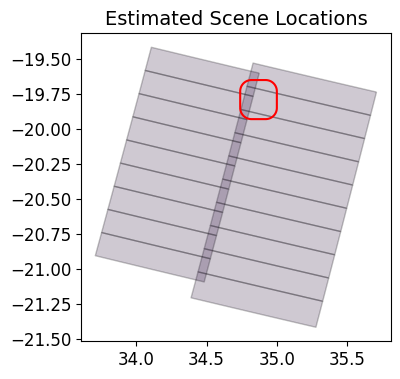

In [74]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

## Reframe Scenes (Optional)

Stitch sequential scenes and crop the subswath to a smaller area for faster processing when the full area is not needed.

In [75]:
sbas.compute_reframe(AOI)

Reframing:   0%|          | 0/6 [00:00<?, ?it/s]

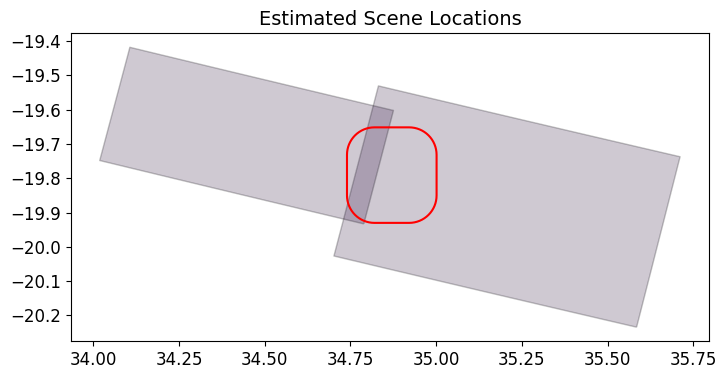

In [76]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

### Load DEM

The function below loads DEM from file or Xarray variable and converts heights to ellipsoidal model using EGM96 grid.

In [77]:
# define the area of interest (AOI) to speedup the processing
sbas.load_dem(DEM, AOI)

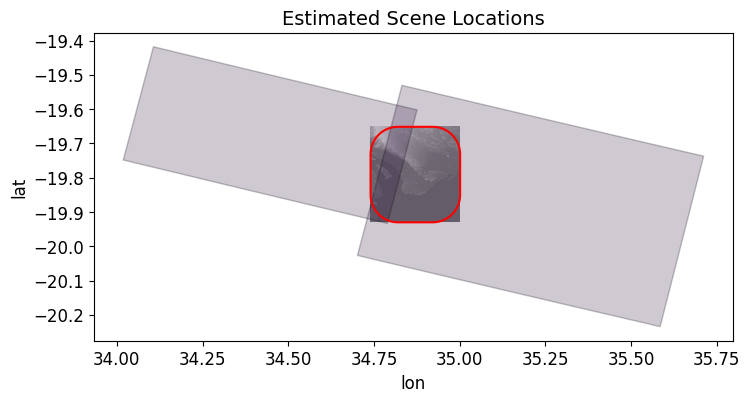

In [78]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

## Align Images

In [79]:
if os.path.exists('/.dockerenv') and not 'google.colab' in sys.modules:
    # use special joblib backend in Docker containers
    sbas.compute_align(joblib_aligning_backend='threading')
else:
    sbas.compute_align()

Aligning Reference:   0%|          | 0/2 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/4 [00:00<?, ?it/s]

Merging Subswaths:   0%|          | 0/3 [00:00<?, ?it/s]

## Geocoding Transform

In [80]:
sbas.compute_geocode(45.)

Radar Transform Computing:   0%|          | 0/1 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

INFO:distributed.scheduler:Receive client connection: Client-worker-f4aa3384-4c53-11ef-ac6a-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:36462
INFO:distributed.scheduler:Receive client connection: Client-worker-f4b3471d-4c53-11ef-ac69-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:36470


Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

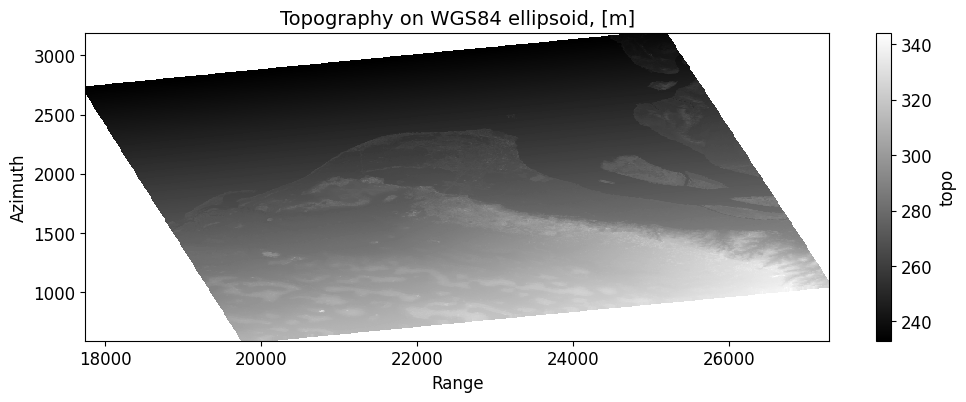

In [81]:
sbas.plot_topo()
plt.savefig('Topography in Radar Coordinates.jpg')

## Interferogram

The code below is detailed for education reasons and can be more compact excluding optional arguments. See other PyGMTSAR examples for shorter version.

In [82]:
# define two correlation maps
pairs = np.asarray([sbas.to_dataframe().index[:-1], sbas.to_dataframe().index[1:]])
pairs

array([['2019-03-02', '2019-03-14'],
       ['2019-03-14', '2019-03-26']], dtype=object)

In [83]:
# load radar topography
topo = sbas.get_topo()
# load Sentinel-1 data
data = sbas.open_data()
intensity = sbas.multilooking(np.square(np.abs(data)), wavelength=400, coarsen=(3,12))
# calculate phase difference with topography correction
phase = sbas.phasediff(pairs, data, topo)
phase = sbas.multilooking(phase, wavelength=400, coarsen=(3,12))
corr = sbas.correlation(phase, intensity)
# materialize
tqdm_dask(corr := dask.persist(corr)[0], desc='Compute Correlation')
corr

Compute Correlation:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

<xarray.DataArray 'correlation' (pair: 2, y: 866, x: 794)> Size: 6MB
dask.array<concatenate, shape=(2, 866, 794), dtype=float32, chunksize=(1, 866, 794), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 7kB 593.5 596.5 599.5 ... 3.182e+03 3.186e+03 3.188e+03
  * x        (x) float64 6kB 1.776e+04 1.777e+04 ... 2.726e+04 2.727e+04
  * pair     (pair) <U21 168B '2019-03-02 2019-03-14' '2019-03-14 2019-03-26'
    ref      (pair) datetime64[ns] 16B 2019-03-02 2019-03-14
    rep      (pair) datetime64[ns] 16B 2019-03-14 2019-03-26

In [84]:
# geocode
corr_ll = sbas.ra2ll(corr)

In [1]:
sbas.plot_correlations(corr_ll.where(corr_ll<0.2), cols=2, cmap='turbo', caption='Correlation Lost: Indicates Flooding')

NameError: name 'sbas' is not defined

In [86]:
# prepare topography and correlation
dem = sbas.get_dem().interp_like(corr_ll).where(np.isfinite(corr_ll.mean('pair')))
gmap = XYZTiles().download(dem, 12)
#.interp_like(corr_ll)

XYZ Tiles Downloading:   0%|          | 0/16 [00:00<?, ?it/s]

In [87]:
sbas.export_vtk(corr_ll[0], 'before', image=gmap)
sbas.export_vtk(corr_ll[1], 'after',  image=gmap)

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [88]:
corr_ll

<xarray.DataArray 'correlation' (pair: 2, lat: 709, lon: 622)> Size: 4MB
dask.array<concatenate, shape=(2, 709, 622), dtype=float32, chunksize=(1, 709, 622), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -19.93 -19.93 -19.93 ... -19.65 -19.65 -19.65
  * lon      (lon) float64 5kB 34.74 34.74 34.74 34.74 ... 35.0 35.0 35.0 35.0
  * pair     (pair) <U21 168B '2019-03-02 2019-03-14' '2019-03-14 2019-03-26'
    ref      (pair) datetime64[ns] 16B 2019-03-02 2019-03-14
    rep      (pair) datetime64[ns] 16B 2019-03-14 2019-03-26

In [ ]:
plotter = pv.Plotter(shape=(1, 2), notebook=True)
axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

def read_mesh(name):
    mesh = pv.read(f'{name}.vtk').scale([1, 1, 0.00005], inplace=True).rotate_z(135, point=axes.origin, inplace=True)
    correlation_data = mesh['correlation']
    opacity_data = np.ones_like(correlation_data, dtype=np.float64)  # Initialize with all values as 1.0 (fully opaque)
    opacity_data[correlation_data < 0.02] = 0.0
    opacity_normalized = (opacity_data - opacity_data.min()) / (opacity_data.max() - opacity_data.min())
    combined_scalars = np.column_stack((mesh['colors'], opacity_normalized))
    mesh['colors'][correlation_data < 0.015] = [70, 130, 180]
    return mesh

plotter.subplot(0, 0)
plotter.add_mesh(read_mesh('before'), scalars='colors', rgb=True, ambient=0.02)
plotter.add_title(f'Interactive Sentinel-1 Flooding Map: Before', font_size=32)

plotter.subplot(0, 1)
plotter.add_mesh(read_mesh('after'), scalars='colors', rgb=True, ambient=0.02)
plotter.add_title(f'Interactive Sentinel-1 Flooding Map: After', font_size=32)

plotter.show_axes()
plotter.show(screenshot='Interactive Sentinel-1 Flooding Map.png', jupyter_backend='panel', return_viewer=True)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

ERROR:root:bad X server connection. DISPLAY=:638110518. Aborting.


## Conclusion

For now you have the full control on interferometry processing and able to run it everywhere: on free of charge Google Colab instances, on local MacOS and Linux computers and on Amazon EC2 and Google Cloud VM and AI Notebook instances.

In [ ]:
corr1 = corr_ll.where(corr_ll<0.02)[0].to_dataframe().reset_index()
corr2 = corr_ll.where(corr_ll<0.02)[1].to_dataframe().reset_index()

In [ ]:
corr1.head()

In [ ]:
corr1=corr1[corr1["correlation"]>=0]
corr2=corr2[corr2["correlation"]>=0]

In [ ]:
corr1

In [ ]:
corr2

In [ ]:
corr2.to_csv('corr2.csv', index=False)

In [ ]:
corr1.to_csv('corr1.csv', index=False)